In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pylab as plt
import datetime
import cmocean
import numpy as np
import dateutil
import scipy.interpolate as scint

In [11]:
def glodap_to_model(model,obs,ovar_name):

    bgc_ovar_names = ['dissic','no3','po4','talk']

    # z distance is much less than distance between stations
    scale_factor = model.dx.mean().values*1e3

    ovar_obs = obs.iloc[0:,2].values.ravel()
    
    stations_obs = obs.station.values.ravel()
    depth_obs = obs.depth.values.ravel()
    

    


    stations_model = model.station.values.ravel()
    depth_model = model.depth.values.ravel()

    stations_model,depth_model = np.meshgrid(stations_model,depth_model)

    interpolated_obs = scint.griddata((stations_obs, depth_obs/scale_factor),ovar_obs,
                              (stations_model, depth_model/scale_factor),
                              method='cubic')

    interpolated_obs = xr.DataArray(interpolated_obs,dims = model.dims, coords = model.coords,attrs=model[ovar_name].attrs)
    interpolated_obs = interpolated_obs.where(~np.isnan(model[ovar_name]))
    interpolated_obs = interpolated_obs.to_dataset(name=ovar_name)
    
    return interpolated_obs

In [2]:
ovar_name_list = ['thetao','so','cfc11','sf6','dissic','no3','po4','talk']
bgc_ovar_names = ['dissic','no3','po4','talk']


model2goldap_ovar_name = {'thetao':'theta',
                          'so':'salinity',
                          'cfc11':'cfc11',
                          'sf6':'sf6',
                          'dissic':'tco2',
                          'no3':'no3',
                          'po4':'po4',
                          'talk':'talk',
                         }

cfactor = {'thetao':1,
           'so':1,
           'cfc11':1,
           'sf6':1,
           'dissic':1e3,
           'no3':1e3,
           'po4':1e3,
           'talk':1e4,
           }

In [4]:
glodap = pd.read_csv('../../qc/GLODAPv2.2019_Merged_Master_File.csv')
glodap[glodap==-9999]= np.NaN
glodap

,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
5,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
6,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
7,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
8,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
9,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0


In [5]:
coords = pd.read_csv('../../qc/GLODAPv2.2019_COORDS.csv')
coords

,Unnamed: 0,bearing,cruise,dx,latitude,longitude,month,year
0,0,0.000000,15.0,0.000000,-53.00800,0.03060,1.0,2005.0
1,1,178.251596,15.0,54.844928,-53.50100,0.00530,1.0,2005.0
2,2,179.993223,15.0,55.263879,-53.99800,0.00520,1.0,2005.0
3,3,-178.246834,15.0,57.181294,-54.51200,0.03230,1.0,2005.0
4,4,178.652229,15.0,54.500775,-55.00200,0.01220,2.0,2005.0
5,5,179.655321,15.0,55.487285,-55.50100,0.00690,2.0,2005.0
6,6,179.666518,15.0,7.561383,-55.56900,0.00620,2.0,2005.0
7,7,179.578260,15.0,48.148722,-56.00200,0.00050,2.0,2005.0
8,8,-179.865827,15.0,55.041642,-56.49700,0.00260,2.0,2005.0
9,9,-178.361315,15.0,51.727059,-56.96200,0.02700,2.0,2005.0


In [6]:
expc = pd.read_csv('../../qc/FILTERED_GLODAP_EXPOCODE.csv')
expc

,Unnamed: 0,ID,EXPOCODE,LINE
0,14,15,06AQ20050122,A12
1,17,18,06AQ20071128,A12
2,18,19,06AQ20080210,A12
3,19,20,06AQ20101128,A12 SR04
4,22,23,06GA19960613,AR19
5,44,45,06MT19970815,AR07E
6,48,49,06MT20010507,A02
7,50,51,06MT20010717,A02
8,67,68,09AR19960822,SR03
9,68,69,09AR19980228,SR03


In [8]:
model = 'CanESM5'
ovar_name = 'dissic'
expocode = '06AQ20050122'
cruise_id = 15

# for expocode,cruise_id in zip(expc['EXPOCODE'],expc['ID'])

section_obs = glodap[glodap.cruise==cruise_id]

section_model = xr.open_mfdataset(f'../../../sections/{ovar_name}_{model}_*_{expocode}.nc')
section_obs_lat = np.round(section_obs.groupby('station').mean()['latitude'],decimals=3)
station_filter = section_obs_lat[section_obs_lat.isin(np.round(section_model.lat.values,decimals=3))]
section_obs = section_obs[section_obs.station.isin(station_filter.index)]
section_model['station'] = station_filter.index.values

section_obs = section_obs[['station','depth',model2goldap_ovar_name[ovar_name]]]
section_obs = section_obs.dropna()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # Remove the CWD from sys.path while we load stuff.
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [12]:
obs = section_obs[['station','depth',model2goldap_ovar_name[ovar_name]]].dropna()
model = section_model

interpolated_obs = glodap_to_model(model,obs,ovar_name)

(0, 176)

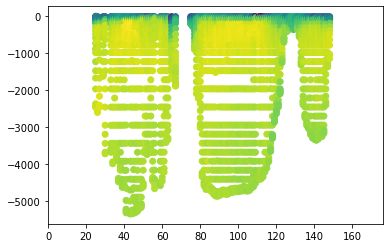

In [13]:
plt.scatter(obs.station,-obs.depth,c=obs[model2goldap_ovar_name[ovar_name]])
plt.xlim(0,176)

(0, 176)

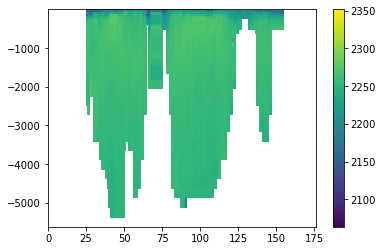

In [14]:
cax = plt.pcolormesh(interpolated_obs.station,-interpolated_obs.depth,interpolated_obs.dissic)
plt.colorbar()
plt.xlim(0,176)

(0, 176)

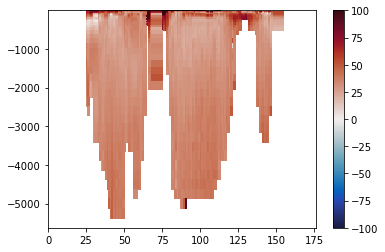

In [15]:
delta = model.dissic*1e3-interpolated_obs.dissic
plt.pcolormesh(interpolated_obs.station,-interpolated_obs.depth,delta.T,vmin=-100,vmax=100,cmap=cmocean.cm.balance)
plt.colorbar()
plt.xlim(0,176)